<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Mohammad Bagher Soltani 
### Student Number : 98105813
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [33]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from copy import deepcopy

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [35]:
###############################################################
##                Compose your transformations               ##
###############################################################
norm_mean, norm_std = 0.1307, 0.3081
transformation = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=norm_mean, std=norm_std)
]) # Write your code here

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [36]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [37]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # Write your code here
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True) # Write your code here

In [38]:
next(iter(train_loader))

[tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
       

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1acQve-TOYd6wYtogpHCblhoDZt9jWQdf/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [39]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        layers_dict = {}
        layers_dict["Res1"] = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        layers_dict["AddRes1"] = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        layers_dict["Res2"] = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        layers_dict["AddRes2"] = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        layers_dict["OUT"] = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=10) 
        )
        self.nn_layers = nn.ModuleDict(layers_dict)

    def forward(self, x):
        res1 = self.nn_layers["Res1"](x)
        add_res1 = self.nn_layers["AddRes1"](res1) + res1
        res2 = self.nn_layers["Res2"](add_res1)
        add_res2 = self.nn_layers["AddRes2"](res2) + res2
        out = self.nn_layers["OUT"](add_res2)
        return out

# Train Model (30 Points)

In [40]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
lr = 1e-4

model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss() # Write your code here
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Write your code here

In [ ]:
import numpy as np

def update_confusion_matrix(conf_matrix, preds, reals):
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            conf_matrix[i, j] += np.sum((reals == i) & (preds == j))
    return conf_matrix

def f1_score(confusion_matrix):
    f1_score = None
    f1_scores = np.zeros(confusion_matrix.shape[0])
    for i in range(confusion_matrix.shape[0]):
        precision = 0.0
        recall = 0.0
        if np.sum(confusion_matrix[:, i]) != 0:
            precision = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])
        if np.sum(confusion_matrix[i, :]) != 0:
            recall = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :])
        if precision + recall == 0:
            f1_scores[i] = 0
        else:
            f1_scores[i] = 2 * recall * precision / (recall + precision)
    f1_score = np.mean(f1_scores)
    return f1_score

def accuracy_score(confusion_matrix):
    if np.sum(confusion_matrix) == 0:
        return 0
    return np.trace(confusion_matrix) / np.sum(confusion_matrix)

In [42]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
train_total_step = len(train_loader)
val_total_step = len(val_loader)
train_losses = []
train_accs = []
train_f1s = []
val_losses = []
val_accs = []
val_f1s = []
num_epochs = 20
best_model = None
best_val_loss = np.Inf

for epoch in range(num_epochs):
    train_loss = 0.0
    N = 0
    conf_matrix = np.zeros((10, 10))
    with tqdm(enumerate(train_loader), total=train_total_step) as pbar:
        for i, (images, labels) in pbar:  
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            outputs = torch.argmax(torch.softmax(preds, dim=1) ,dim=1)
            loss = criterion(preds, labels)
            N += len(images)
            train_loss += loss.detach()
            loss.backward()
            optimizer.step()

            update_confusion_matrix(conf_matrix, outputs.cpu().numpy(), labels.cpu().numpy())
            acc = accuracy_score(conf_matrix)
            f1 = f1_score(conf_matrix)
            pbar.set_description(f'Train {epoch} | Loss: {train_loss/N:.3e} | Accuracy: {acc:.3f} | F1: {f1:.3f}')

    train_losses.append(train_loss / N)
    train_accs.append(accuracy_score(conf_matrix))
    train_f1s.append(f1_score(conf_matrix))

    val_loss = 0.0
    N = 0
    conf_matrix = np.zeros((10, 10))
    with torch.no_grad():
        with tqdm(enumerate(val_loader), total=val_total_step) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)
                preds = model(images)
                outputs = torch.argmax(torch.softmax(preds, dim=1) ,dim=1)
                loss = criterion(preds, labels)
                N += len(images)
                val_loss += loss.detach()

                update_confusion_matrix(conf_matrix, outputs.cpu().numpy(), labels.cpu().numpy())
                acc = accuracy_score(conf_matrix)
                f1 = f1_score(conf_matrix)
                pbar.set_description(f'Val {epoch} | Loss: {val_loss/N:.3e} | Accuracy: {acc:.3f} | F1: {f1:.3f}')
    
    val_losses.append(val_loss / N)
    val_accs.append(accuracy_score(conf_matrix))
    val_f1s.append(f1_score(conf_matrix))

    if val_losses[-1] < best_val_loss:
        best_model = deepcopy(model)
        best_val_loss = val_losses[-1]

Train 0 | Loss: 5.225e-02 | Accuracy: 0.723 | F1: 0.720: 100%|██████████| 3125/3125 [00:56<00:00, 55.75it/s]
Val 0 | Loss: 1.870e-02 | Accuracy: 0.914 | F1: 0.914: 100%|██████████| 625/625 [00:07<00:00, 84.77it/s]
Train 1 | Loss: 1.636e-02 | Accuracy: 0.922 | F1: 0.922: 100%|██████████| 3125/3125 [01:01<00:00, 50.66it/s]
Val 1 | Loss: 1.162e-02 | Accuracy: 0.945 | F1: 0.945: 100%|██████████| 625/625 [00:07<00:00, 82.91it/s]
Train 2 | Loss: 1.159e-02 | Accuracy: 0.943 | F1: 0.943: 100%|██████████| 3125/3125 [00:59<00:00, 52.48it/s]
Val 2 | Loss: 1.175e-02 | Accuracy: 0.940 | F1: 0.940: 100%|██████████| 625/625 [00:06<00:00, 90.28it/s]
Train 3 | Loss: 8.948e-03 | Accuracy: 0.956 | F1: 0.956: 100%|██████████| 3125/3125 [00:57<00:00, 54.73it/s]
Val 3 | Loss: 7.215e-03 | Accuracy: 0.966 | F1: 0.965: 100%|██████████| 625/625 [00:07<00:00, 88.11it/s] 
Train 4 | Loss: 7.548e-03 | Accuracy: 0.963 | F1: 0.963: 100%|██████████| 3125/3125 [01:00<00:00, 51.91it/s]
Val 4 | Loss: 6.409e-03 | Accuracy

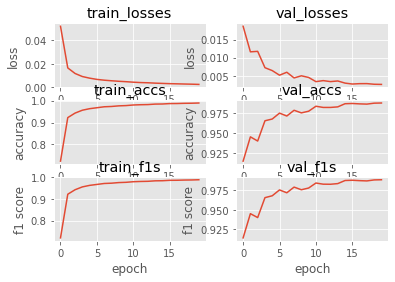

In [43]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
fig, axs = plt.subplots(nrows = 3, ncols = 2)
# loss
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("train_losses")
axs[0, 1].plot(val_losses)
axs[0, 1].set_title("val_losses")
for ax in axs[0]:
    ax.set(ylabel="loss")

# acc
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("train_accs")
axs[1, 1].plot(val_accs)
axs[1, 1].set_title("val_accs")
for ax in axs[1]:
    ax.set(ylabel="accuracy")

# f1
axs[2, 0].plot(train_f1s)
axs[2, 0].set_title("train_f1s")
axs[2, 1].plot(val_f1s)
axs[2, 1].set_title("val_f1s")
for ax in axs[2]:
    ax.set(ylabel="f1 score")

for ax in axs.flat:
    ax.set(xlabel="epoch")

plt.show()

# Test Model (20 Points)

10000


Test | Loss: 5.401e-04: 100%|██████████| 157/157 [00:04<00:00, 37.66it/s]


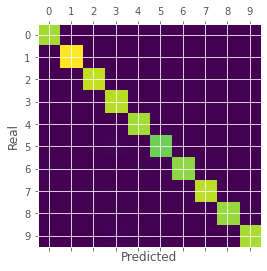

Test Accuracy: 0.9884
Test F1 Score: 0.9883212218480363


In [46]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
test_total_step = len(test_loader)
print(len(test_data))

test_loss = 0.0
N = 0
conf_matrix = np.zeros((10, 10))
with torch.no_grad():
    with tqdm(enumerate(test_loader), total=test_total_step) as pbar:
        for i, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            outputs = torch.argmax(torch.softmax(preds, dim=1) ,dim=1)
            loss = criterion(preds, labels)
            N += len(images)
            test_loss += loss.detach()

            update_confusion_matrix(conf_matrix, outputs.cpu().numpy(), labels.cpu().numpy())
            pbar.set_description(f'Test | Loss: {test_loss/N:.3e}')

plt.matshow(conf_matrix)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

print(f'Test Accuracy: {accuracy_score(conf_matrix)}')
print(f'Test F1 Score: {f1_score(conf_matrix)}')
